In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import decomposition
import copy
import time
import random
import CTRNN
from CTRNN import Trial


torch.manual_seed(66)
np.random.seed(66)
random.seed(66)

In [2]:
t0 = Trial(stimulus=0)
t1 = Trial(stimulus=1)        

In [3]:
def plot_trial(ax, data, part):
    if part == 'stimulus':
        ax.imshow(data.stimulus.transpose(0,1))
    elif part == 'target':
        ax.imshow(data.target.transpose(0,1))

    ax.set_xticks(np.arange((data.duration*2)+0.1)-0.5)
    ax.set_xticklabels(np.array(data.step_lims))  
    ax.axhline(y=0.5, color='k', linestyle='-', linewidth=2)
    ax.xaxis.grid(True, color='k', linestyle='-', linewidth=2)
    ax.set(xlabel="time (s)", ylabel="neuron #")


def plot_output(ax, trial_type, data):
    ax.imshow(data.detach().numpy().transpose())
    ax.set_xticks(np.arange((trial_type.duration*2)+0.1)-0.5)
    ax.set_xticklabels(np.array(trial_type.step_lims))  
    ax.axhline(y=0.5, color='k', linestyle='-', linewidth=2)
    ax.xaxis.grid(True, color='k', linestyle='-', linewidth=2)
    ax.set(xlabel="time (s)", ylabel="neuron #")

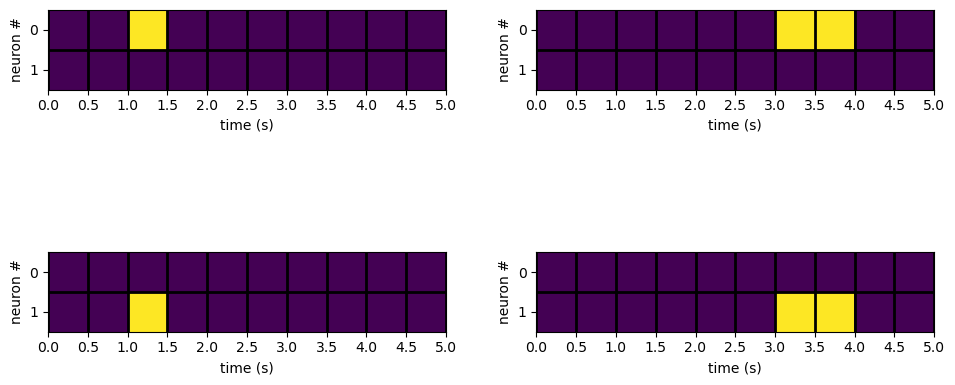

In [4]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
plot_trial(axs[0,0], t0, 'stimulus')
plot_trial(axs[0,1], t0, 'target')
plot_trial(axs[1,0], t1, 'stimulus')
plot_trial(axs[1,1], t1, 'target')
fig.set_size_inches(10, 5)


In [5]:
# create a bunch of trials - so we're not creating them on the fly

ntrials = 10000
trials = [CTRNN.Trial(stimulus=random.randint(0,1)) for item in range(ntrials)]

In [6]:
# create a network and train it
# also create a copy in order to compare the trained network to the untrained network

net = CTRNN.CTRNN(2, 100, 2)
naiive_net = copy.deepcopy(net)

criterion = nn.MSELoss()
learningrate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learningrate)
optimizer.zero_grad()

losstrack = []

loss = 1
while loss >= 0.01:
    for i in range(ntrials):
        t = trials[i]
        out, _ = net(t.stimulus)
        target = t.target
        loss = criterion(out, target)
        losstrack.append(loss.item())
        loss.backward()
        optimizer.step()

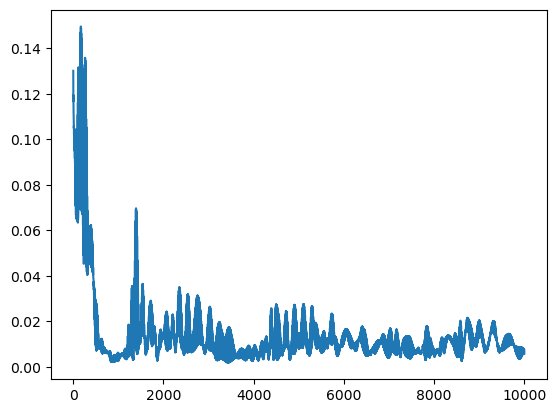

In [7]:
plt.plot(losstrack)

In [8]:
# get output and hidden activity for each stim for naiive network

out_og_t0, h0_og = naiive_net(t0.stimulus)
out_og_t1, h1_og = naiive_net(t1.stimulus)

#  get output and hidden activity for each stim for trained network

out_t0, h0 = net(t0.stimulus)
out_t1, h1 = net(t1.stimulus)


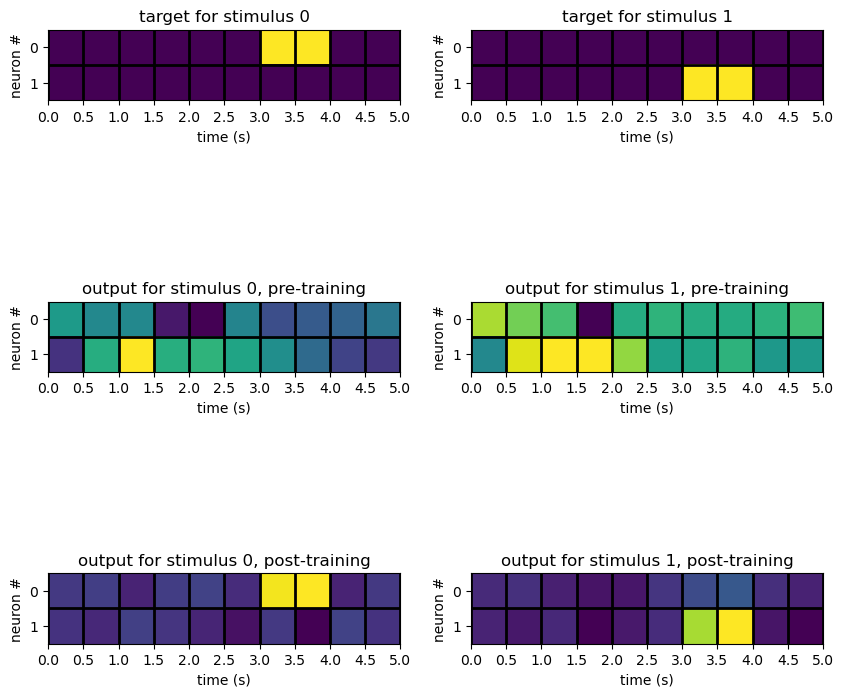

In [9]:
fig, axs = plt.subplots(3, 2)
plot_trial(axs[0,0], t0, 'target')
plot_output(axs[1,0], t0, out_og_t0)
plot_output(axs[2,0], t0, out_t0)
axs[0,0].set_title("target for stimulus 0")
axs[1,0].set_title("output for stimulus 0, pre-training")
axs[2,0].set_title("output for stimulus 0, post-training")


plot_trial(axs[0,1], t1, 'target')
plot_output(axs[1,1], t1, out_og_t1)
plot_output(axs[2,1], t1, out_t1)
axs[0,1].set_title("target for stimulus 1")
axs[1,1].set_title("output for stimulus 1, pre-training")
axs[2,1].set_title("output for stimulus 1, post-training")

fig.set_size_inches(10, 10)

In [10]:
def sort_by_peak(data):
    data = data.detach().numpy().transpose()
    max_idx = data.argmax(axis=1)
    sort_idx = np.argsort(max_idx)
    sorted = data[sort_idx]
    return sorted



def plot_hidden(ax, trial_type, data, sorted=False):
    if sorted==True:
        data = sort_by_peak(data)
    else:
        data = data.detach().numpy().transpose()
    ax.imshow(data,aspect='auto')
    ax.aspect = 'equal'
    ax.set_xticks(np.arange((trial_type.duration*2)+0.1)-0.5)
    ax.set_xticklabels(np.array(trial_type.step_lims))  
    ax.axhline(y=0.5, color='k', linestyle='-', linewidth=1)
    ax.xaxis.grid(True, color='k', linestyle='-', linewidth=1)
    ax.set(xlabel="time (s)", ylabel="hidden neuron #")


Text(0.5, 1.0, 'hidden activity for stimulus 1, post-training')

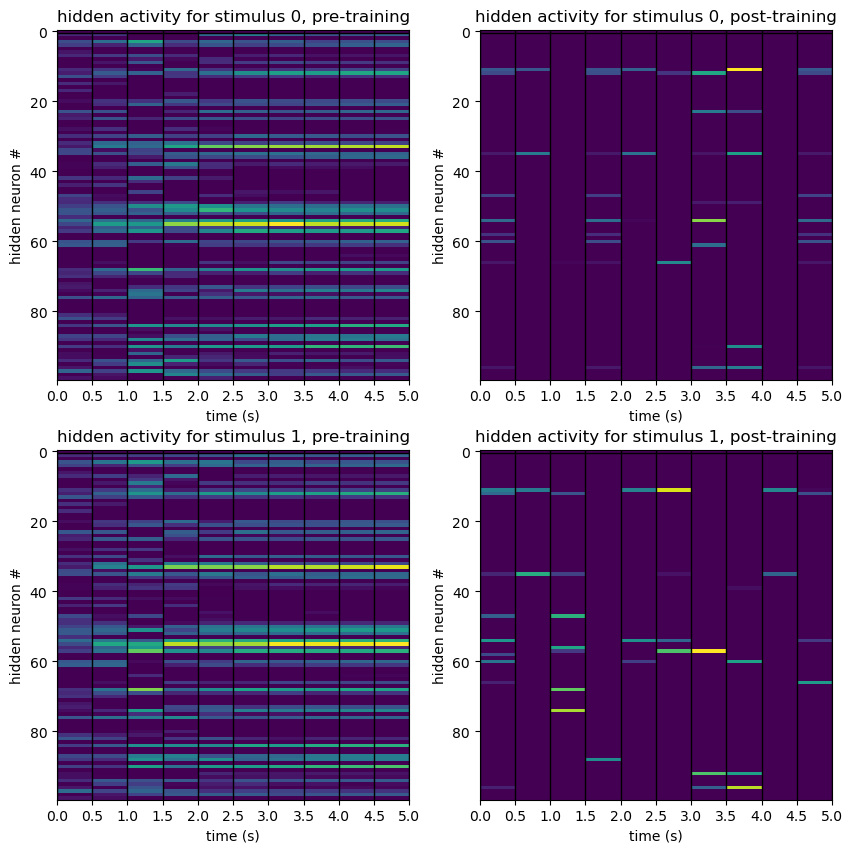

In [11]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

plot_hidden(axs[0,0], t0, h0_og)
plot_hidden(axs[0,1], t0, h0)
plot_hidden(axs[1,0], t0, h1_og)
plot_hidden(axs[1,1], t0, h1)

axs[0,0].set_title("hidden activity for stimulus 0, pre-training")
axs[0,1].set_title("hidden activity for stimulus 0, post-training")
axs[1,0].set_title("hidden activity for stimulus 1, pre-training")
axs[1,1].set_title("hidden activity for stimulus 1, post-training")

Text(0.5, 1.0, 'hidden weight matrix post-training')

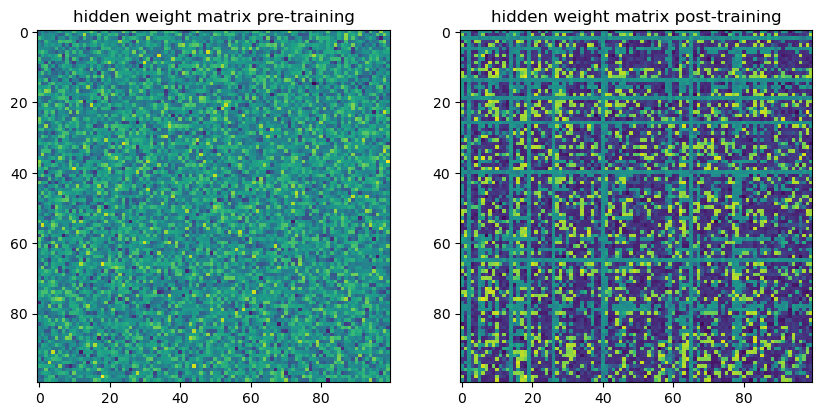

In [12]:
# show weight matrix
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
axs[0].imshow(naiive_net.h2h.weight.detach().numpy())  
axs[1].imshow(net.h2h.weight.detach().numpy())  

axs[0].set_title("hidden weight matrix pre-training")
axs[1].set_title("hidden weight matrix post-training")


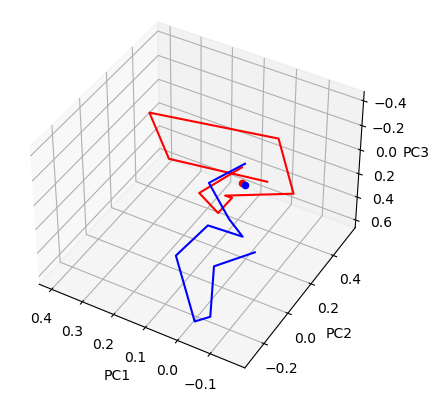

In [89]:
from scipy.ndimage import gaussian_filter1d

activity_cat = np.concatenate([h0.detach().numpy(), h1.detach().numpy()])
pca = decomposition.PCA(n_components=3)
pca.fit(activity_cat)

activity_pc_s0 = gaussian_filter1d(pca.transform(h0.detach().numpy()),axis=0,sigma=1)
activity_pc_s1 = gaussian_filter1d(pca.transform(h1.detach().numpy()),axis=0,sigma=1)

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(activity_pc_s0[0, 0], activity_pc_s0[0, 1], color='red')
ax.scatter(activity_pc_s1[0, 0], activity_pc_s1[0, 1], color='blue')

ax.plot(activity_pc_s0[:, 0], activity_pc_s0[:, 1], activity_pc_s0[:, 2], color='red')
ax.plot(activity_pc_s1[:, 0], activity_pc_s1[:, 1],activity_pc_s1[:, 2], color='blue')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
ax.view_init(-140, 60) 


[Text(0.5, 0, 'time (s)'), Text(0, 0.5, 'euclidean distance (a.u.)')]

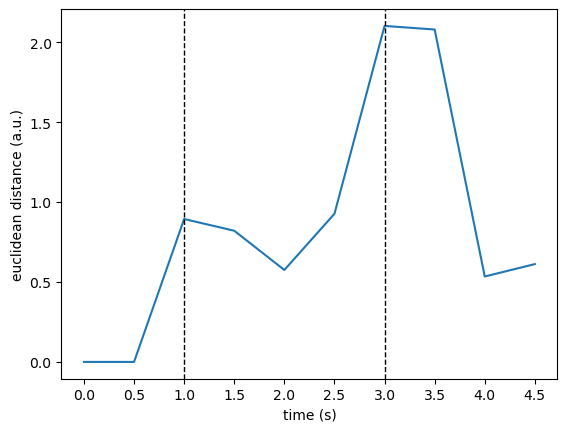

In [60]:
# euclidean distance between hidden activity for stimulus 0 and stimulus 1

dist = ((activity_pc_s1[:, 0]-activity_pc_s0[:, 0])**2 + (activity_pc_s1[:, 1]-activity_pc_s0[:, 1])**2 + (activity_pc_s1[:, 2]-activity_pc_s0[:, 2])**2)**0.5
ax = plt.plot(dist)
ax = plt.xticks(ticks=np.arange(0, 10, 1),labels=np.arange(0, 5, 0.5))
ax = plt.gca()
ax.axvline(x=1*2, color='k', linestyle='--', linewidth=1)
ax.axvline(x=3*2, color='k', linestyle='--', linewidth=1)
ax.set(xlabel="time (s)", ylabel="euclidean distance (a.u.)")

In [46]:
dist.shape

(10,)

In [27]:
np.arange(0, 5, 0.5).shape

(10,)

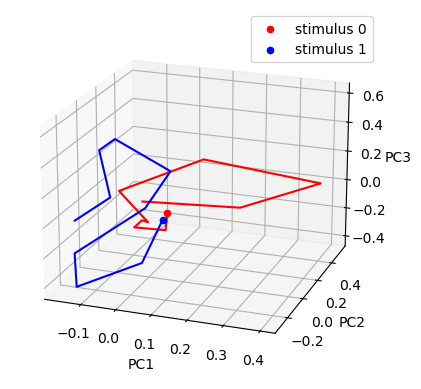

In [115]:
from scipy.ndimage import gaussian_filter1d

activity_cat = np.concatenate([h0.detach().numpy(), h1.detach().numpy()])
pca = decomposition.PCA(n_components=3)
pca.fit(activity_cat)

activity_pc_s0 = gaussian_filter1d(pca.transform(h0.detach().numpy()),axis=0,sigma=1)
activity_pc_s1 = gaussian_filter1d(pca.transform(h1.detach().numpy()),axis=0,sigma=1)

ax = plt.figure().add_subplot(projection='3d')

ax.scatter(activity_pc_s0[0, 0], activity_pc_s0[0, 1], activity_pc_s0[0, 2], color='red')
ax.scatter(activity_pc_s1[0, 0], activity_pc_s1[0, 1], activity_pc_s1[0, 2],color='blue')



ax.plot(activity_pc_s0[:, 0], activity_pc_s0[:, 1], activity_pc_s0[:, 2], color='red')
ax.plot(activity_pc_s1[:, 0], activity_pc_s1[:, 1],activity_pc_s1[:, 2], color='blue')
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')

ax.legend(['stimulus 0', 'stimulus 1'])    
ax.view_init(20, -70) 
